In [1]:
import os
import shutil
import random
from osgeo import gdal
from google.colab import drive
drive.mount("/content/gdrive")
!pip install rasterio
import numpy as np
import rasterio
from rasterio.plot import show, show_hist
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import models
from keras import backend as K
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.metrics import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix

%matplotlib inline

Mounted at /content/gdrive
     |████████████████████████████████| 19.1MB 154kB/s 


In [2]:
!mkdir dataset

In [3]:
!unzip /content/gdrive/MyDrive/EuroSAT.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/2750/SeaLake/SeaLake_2206.jpg  
  inflating: /content/dataset/2750/SeaLake/SeaLake_1313.jpg  
  inflating: /content/dataset/2750/SeaLake/SeaLake_263.jpg  
  inflating: /content/dataset/2750/SeaLake/SeaLake_967.jpg  
  inflating: /content/dataset/2750/SeaLake/SeaLake_515.jpg  
  inflating: /content/dataset/2750/SeaLake/SeaLake_1465.jpg  
  inflating: /content/dataset/2750/SeaLake/SeaLake_1817.jpg  
  inflating: /content/dataset/2750/SeaLake/SeaLake_2902.jpg  
  inflating: /content/dataset/2750/SeaLake/SeaLake_2570.jpg  
  inflating: /content/dataset/2750/SeaLake/SeaLake_1004.jpg  
  inflating: /content/dataset/2750/SeaLake/SeaLake_174.jpg  
  inflating: /content/dataset/2750/SeaLake/SeaLake_2111.jpg  
  inflating: /content/dataset/2750/SeaLake/SeaLake_2388.jpg  
  inflating: /content/dataset/2750/SeaLake/SeaLake_1948.jpg  
  inflating: /content/dataset/2750/SeaLake/SeaLake_838.jpg  
  inflating: /content/da

In [4]:
path = "/content/dataset/2750"
SEED = random.seed(123)

In [5]:
 #get names of categories
categories = []
tif_files = []
for (dirpath, dirnames, filenames) in os.walk(path ):
    categories.extend(dirnames)
    tif_files += filenames


In [6]:
categories

['Residential',
 'SeaLake',
 'River',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Forest',
 'Highway',
 'AnnualCrop',
 'HerbaceousVegetation']

In [7]:
len(tif_files)

27000

In [8]:
#create new folder with test train and valid sets with folders of all categories

# make train, test, valid folders
split_names = ['train', 'test', 'valid']
for sp_name in split_names:
    directory = path + 'land-use-jpeg/' + sp_name + '/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    # make category folders
    for category in categories:
        dir_cat = directory + category + '/'
        if not os.path.exists(dir_cat):
            os.makedirs(dir_cat)

In [9]:

for category in categories:
    directory = path + '/' + category + '/'
    
    directory_train = path + 'land-use-jpeg/train/' + category + '/'
    directory_valid = path + 'land-use-jpeg/test/' + category + '/'
    directory_test = path + 'land-use-jpeg/valid/' + category + '/'
    filenames = os.listdir(directory)
    
    
    filenames.sort()
    random.shuffle(filenames)
    print(len(filenames))
    split_1 = int(0.8 * len(filenames))
    print(split_1)
    split_2 = int(0.9 * len(filenames))
    train_filenames = filenames[:split_1]
    valid_filenames = filenames[split_1:split_2]
    test_filenames = filenames[split_2:]
    print(len(test_filenames))
    print(len(valid_filenames))
    for file in filenames:
      if file in valid_filenames:
         shutil.move( directory+ file, directory_valid + file)
      elif file in test_filenames:
          shutil.move(directory+ file, directory_test + file)
      else :
          shutil.move(directory+ file, directory_train + file)
         

3000
2400
300
300
3000
2400
300
300
2500
2000
250
250
2500
2000
250
250
2000
1600
200
200
2500
2000
250
250
3000
2400
300
300
2500
2000
250
250
3000
2400
300
300
3000
2400
300
300


In [55]:
f=os.listdir (path + 'land-use-jpeg/valid/' + 'River' + '/')


In [56]:
len(f)


250

#Land Use Classification | Exploratory Data Analysis
Before building the deep learning model, it's worth it to get more familiar with the dataset. Especially as an image dataset, visualizations help us see differences in the different image categories as well as the red, green, and blue bands of a single image.

In [57]:

# get names of label folders

categories = []
for (dirpath, dirnames, filenames) in os.walk(path):
    categories.extend(dirnames)
total = 0
len_categories = {}
for category in categories:
  len_files = len(os.listdir(path +'/' + category + '/'))
  total += len_files
  len_categories[category] = len_files

In [58]:
total

0

In [14]:
len_categories

{'AnnualCrop': 0,
 'Forest': 0,
 'HerbaceousVegetation': 0,
 'Highway': 0,
 'Industrial': 0,
 'Pasture': 0,
 'PermanentCrop': 0,
 'Residential': 0,
 'River': 0,
 'SeaLake': 0}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


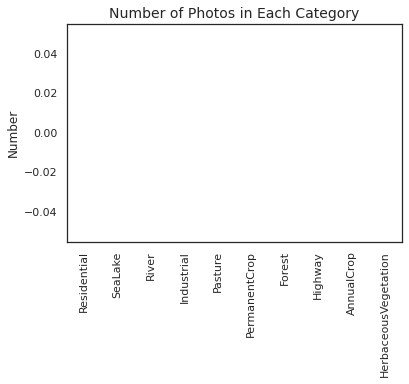

In [54]:
x = list(range(len(len_categories)))
y = list(len_categories.values())
ax = sns.barplot(x, y)
plt.title("Number of Photos in Each Category", fontsize=14)
plt.ylabel("Number")
plt.xticks(x, list(len_categories.keys()), rotation=90)
#plt.tight_layout()
plt.show()

In [16]:

images = [path + 'land-use-jpeg/train/AnnualCrop/AnnualCrop_1.jpg',
         path + 'land-use-jpeg/train/Forest/Forest_1.jpg',
         path + 'land-use-jpeg/train/HerbaceousVegetation/HerbaceousVegetation_1.jpg',
         path + 'land-use-jpeg/train/Highway/Highway_1.jpg',
         path + 'land-use-jpeg/train/Industrial/Industrial_1.jpg',
         path + 'land-use-jpeg/train/Pasture/Pasture_1.jpg',
         path + 'land-use-jpeg/train/PermanentCrop/PermanentCrop_2.jpg',
         path + 'land-use-jpeg/train/Residential/Residential_1.jpg',
         path + 'land-use-jpeg/train/River/River_1.jpg',
         path + 'land-use-jpeg/train/SeaLake/SeaLake_1.jpg']

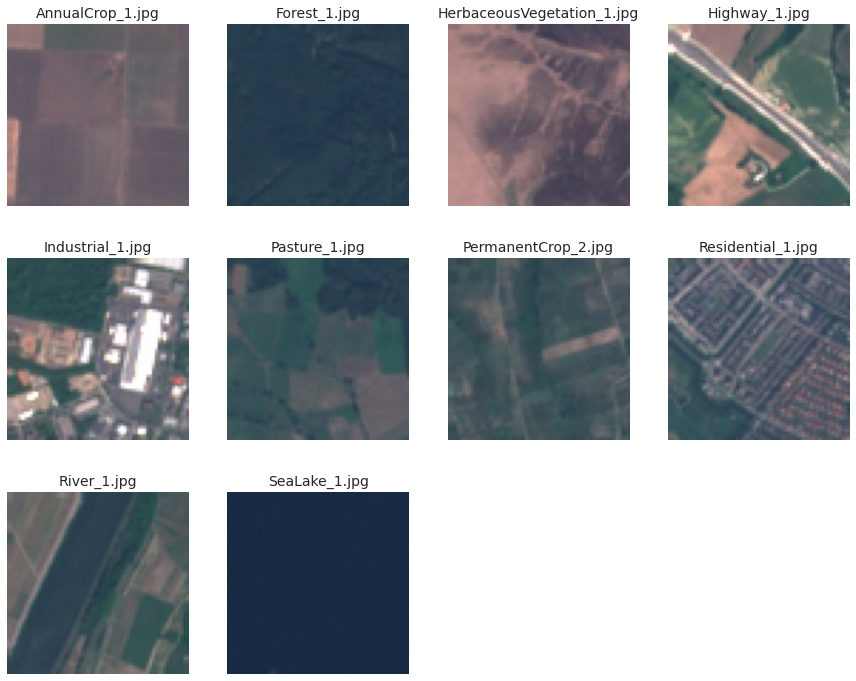

In [17]:
plt.figure(figsize=(12,10))
for i, img in enumerate(images, start=1):
    category = img.split('/')[6]
    plt.subplot(3, 4, i)
    data = plt.imread(img)
    plt.imshow(data)
    plt.axis('off')
    plt.title(category, fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
fp = path + 'land-use-jpeg/train/Forest/Forest_1.jpg'
raster = rasterio.open(fp)

print('Height:', raster.height)
print('Width:', raster.width)
print('Number of bands:', raster.count)

Height: 64
Width: 64
Number of bands: 3


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Text(0.5, 1.0, 'Blue')

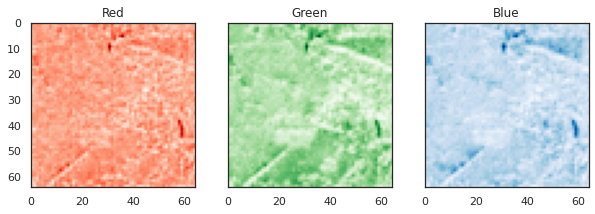

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
show((raster, 3), cmap='Reds', ax=ax1)
show((raster, 2), cmap='Greens', ax=ax2)
show((raster, 1), cmap='Blues', ax=ax3)

# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")

In [20]:
# from https://automating-gis-processes.github.io/CSC/notebooks/L5/plotting-raster.html

red = raster.read(1)
green = raster.read(2)
blue = raster.read(3)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized bands
0.0 - 1.0 mean: 0.2611148231907895
0.0 - 1.0 mean: 0.3365959398674242
0.0 - 1.0 mean: 0.32106119791666665


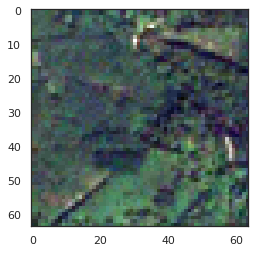

In [21]:
# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.imshow(rgb)

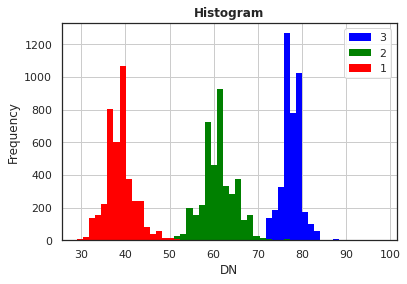

In [22]:

# see how the wavelengths of different bands are distributed
show_hist(raster, bins=50, lw=0.0, stacked=False,
      histtype='stepfilled', title="Histogram")

#CNN model

In [23]:
base_path = path
train_path = os.path.join(base_path+'land-use-jpeg/train')
valid_path = os.path.join(base_path +'land-use-jpeg/valid')
test_path = os.path.join(base_path+'land-use-jpeg/test')

In [24]:
len(train_path )

40

In [25]:
val = os.path.join(valid_path, 'Forest')
len(os.listdir(val))

300

In [26]:
tr = os.path.join(train_path,'Forest' )
len(os.listdir(tr))

2400

In [27]:
for category in categories:
    tr = os.path.join(train_path, category+'/')
    len_tr = len(os.listdir(tr))
    
    val = os.path.join(valid_path, category+'/')
    len_val = len(os.listdir(val))
    
    test = os.path.join(test_path, category+'/')
    len_test = len(os.listdir(val))
    
    print('Train images for ' + category + ': {}'.format(len_tr))
    print('Validation images for ' + category + ': {}'.format(len_val))
    print('Test images for ' + category + ': {}'.format(len_test))
    print('')

Train images for Residential: 2400
Validation images for Residential: 300
Test images for Residential: 300

Train images for SeaLake: 2400
Validation images for SeaLake: 300
Test images for SeaLake: 300

Train images for River: 2000
Validation images for River: 250
Test images for River: 250

Train images for Industrial: 2000
Validation images for Industrial: 250
Test images for Industrial: 250

Train images for Pasture: 1600
Validation images for Pasture: 200
Test images for Pasture: 200

Train images for PermanentCrop: 2000
Validation images for PermanentCrop: 250
Test images for PermanentCrop: 250

Train images for Forest: 2400
Validation images for Forest: 300
Test images for Forest: 300

Train images for Highway: 2000
Validation images for Highway: 250
Test images for Highway: 250

Train images for AnnualCrop: 2400
Validation images for AnnualCrop: 300
Test images for AnnualCrop: 300

Train images for HerbaceousVegetation: 2400
Validation images for HerbaceousVegetation: 300
Test 

In [28]:
train_batches = ImageDataGenerator().flow_from_directory(train_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=20)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=10,
                                                         shuffle=False)

Found 21600 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.


In [29]:
# plots images with labels within jupyter notebook
# from Github / YouTube user deeplizard: https://www.youtube.com/watch?v=LhEMXbjGV_4
def plots(ims, figsize=(30, 15), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims) //rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.tight_layout()
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [30]:

imgs, labels = next(train_batches)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


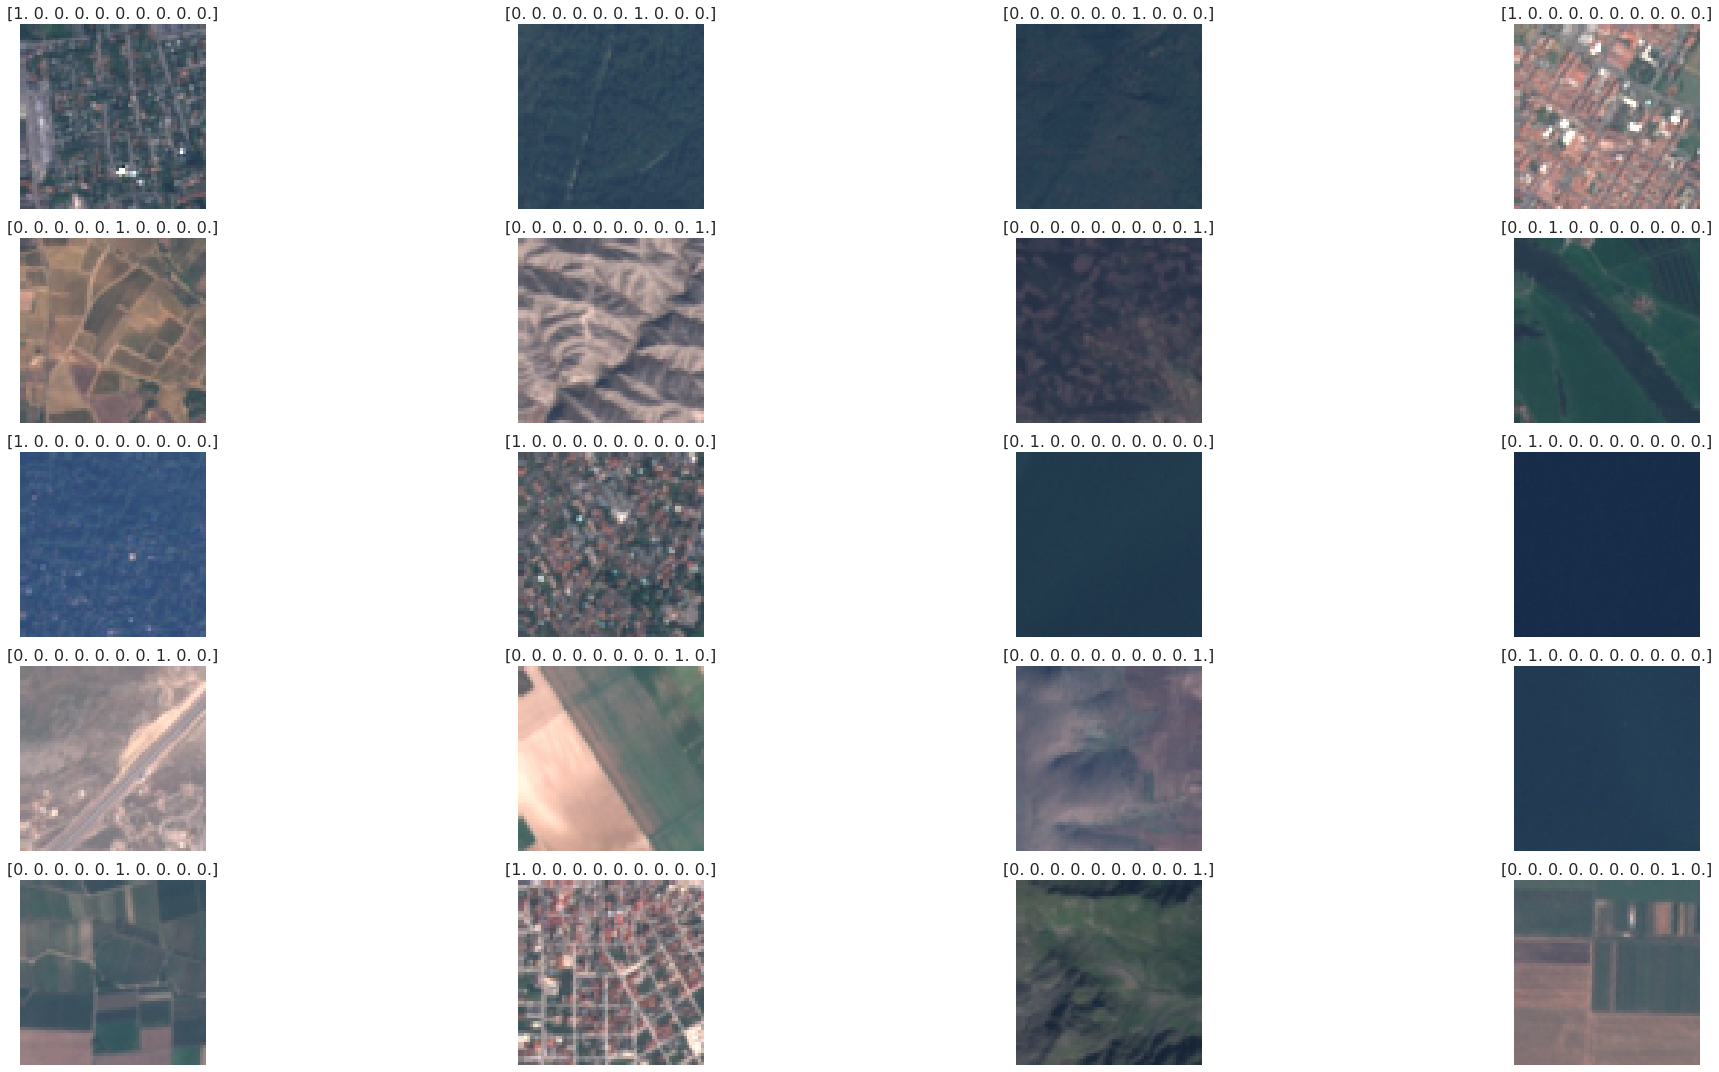

In [31]:
plots(imgs, rows=5, titles=labels)

In [32]:
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64,64,3)), # convolutions
        Flatten(), # flatten into 1-D tensor
        Dense(10, activation='softmax') #output layer that categorizes images
])

model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# fits the model on data generated batch by batch by ImageDataGenerator
model.fit_generator(train_batches, steps_per_epoch=1080,
                   validation_data=valid_batches, validation_steps=270,
                   epochs=5,
                   verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
1080/1080 - 42s - loss: 10.0113 - accuracy: 0.4994 - val_loss: 1.3614 - val_accuracy: 0.6104
Epoch 2/5
1080/1080 - 9s - loss: 0.8563 - accuracy: 0.7220 - val_loss: 1.2449 - val_accuracy: 0.6156
Epoch 3/5
1080/1080 - 9s - loss: 0.5238 - accuracy: 0.8281 - val_loss: 1.2544 - val_accuracy: 0.6656
Epoch 4/5
1080/1080 - 9s - loss: 0.3627 - accuracy: 0.8859 - val_loss: 1.3120 - val_accuracy: 0.6611
Epoch 5/5
1080/1080 - 9s - loss: 0.2926 - accuracy: 0.9101 - val_loss: 1.4814 - val_accuracy: 0.6544


#test_prediction

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


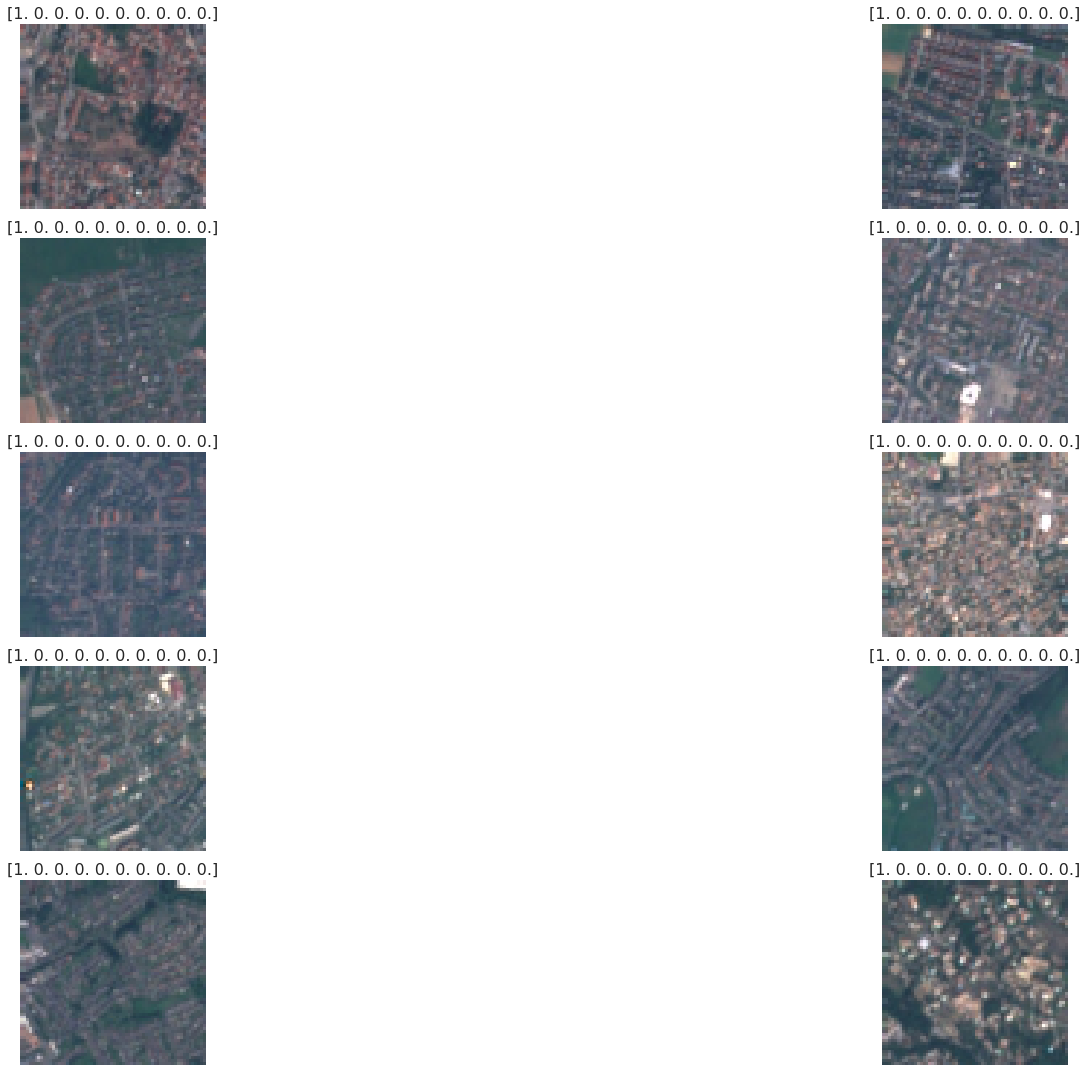

In [33]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, rows=5, titles=test_labels)

In [34]:

test_labels = test_batches.classes
test_labels

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [35]:
test_batches.class_indices

{'AnnualCrop': 8,
 'Forest': 6,
 'HerbaceousVegetation': 9,
 'Highway': 7,
 'Industrial': 3,
 'Pasture': 4,
 'PermanentCrop': 5,
 'Residential': 0,
 'River': 2,
 'SeaLake': 1}

In [36]:
predictions = model.predict(test_batches, steps=270, verbose=0)

In [37]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [38]:

# modified from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes
              )
    if normalize:
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Confusion matrix, without normalization
[[246   0   2  26   0   3   0  15   0   8]
 [  0 280   6   0   2   0   4   1   7   0]
 [  3   1 139   1  21   4  10  57  12   2]
 [ 57   0   3 173   0   2   0  11   0   4]
 [  0   6  28   0  51  11   9  16  66  13]
 [ 10   0  14   8   5  95   0  61  12  45]
 [  0   8  11   0  13   0 249   1  15   3]
 [ 18   0  23   5   6   7   1 168   8  14]
 [  0   3  17   1   9  16   2  45 196  11]
 [ 16   5  14  14   8  22   3  52  21 145]]


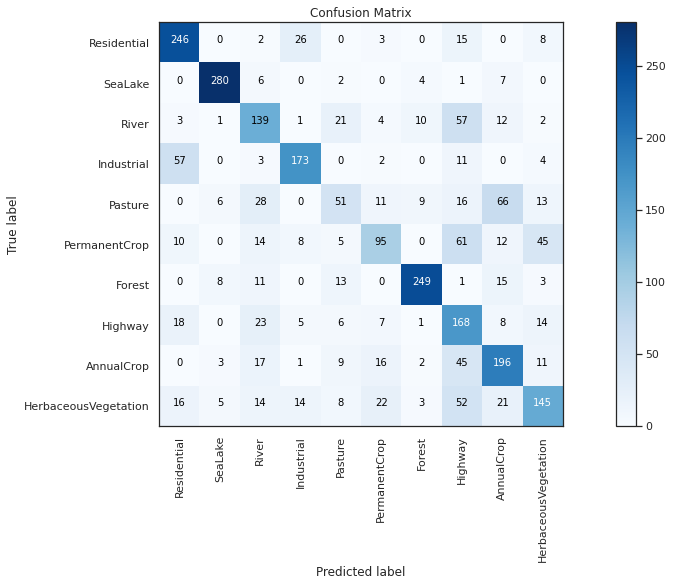

In [39]:
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

#CNN FOR TRANSFER LEARNING

In [40]:
vgg16_model = keras.applications.vgg16.VGG16(include_top=False, input_shape=(64,64,3))

58892288/58889256 [==============================] - 0s 0us/step


In [41]:
vgg16_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [42]:
type(vgg16_model)



tensorflow.python.keras.engine.functional.Functional

In [43]:
keras.engine.training.Model



tensorflow.python.keras.engine.training.Model

In [44]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)



In [45]:
# this sequential model is now the same architecture as the VGG16 model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

In [46]:
# train a certain number of layers to learn about the type of data we're using,
# which is much different than for imagenet
NUM_TRAINABLE_LAYERS = 10
for layer in model.layers[:-NUM_TRAINABLE_LAYERS]:
    layer.trainable = False #excludes layer from future training so weights will not be updated when we train the model on our own data

In [47]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))

In [48]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

In [49]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
history = model.fit(train_batches, steps_per_epoch=1080,
                   validation_data=valid_batches, validation_steps=270,
                   epochs=10,
                   verbose=2)

Epoch 1/10
1080/1080 - 33s - loss: 0.4459 - accuracy: 0.8606 - val_loss: 0.3032 - val_accuracy: 0.8948
Epoch 2/10
1080/1080 - 32s - loss: 0.1917 - accuracy: 0.9408 - val_loss: 0.1586 - val_accuracy: 0.9533
Epoch 3/10
1080/1080 - 32s - loss: 0.1448 - accuracy: 0.9556 - val_loss: 0.1604 - val_accuracy: 0.9533
Epoch 4/10
1080/1080 - 33s - loss: 0.1220 - accuracy: 0.9645 - val_loss: 0.2604 - val_accuracy: 0.9307
Epoch 5/10
1080/1080 - 33s - loss: 0.1052 - accuracy: 0.9681 - val_loss: 0.1581 - val_accuracy: 0.9526
Epoch 6/10
1080/1080 - 33s - loss: 0.0951 - accuracy: 0.9725 - val_loss: 0.1437 - val_accuracy: 0.9622
Epoch 7/10
1080/1080 - 33s - loss: 0.0732 - accuracy: 0.9791 - val_loss: 0.1740 - val_accuracy: 0.9541
Epoch 8/10
1080/1080 - 33s - loss: 0.0631 - accuracy: 0.9821 - val_loss: 0.1546 - val_accuracy: 0.9556
Epoch 9/10
1080/1080 - 33s - loss: 0.0695 - accuracy: 0.9804 - val_loss: 0.2130 - val_accuracy: 0.9485
Epoch 10/10
1080/1080 - 33s - loss: 0.0557 - accuracy: 0.9850 - val_loss:

In [51]:
test_batches.class_indices

{'AnnualCrop': 8,
 'Forest': 6,
 'HerbaceousVegetation': 9,
 'Highway': 7,
 'Industrial': 3,
 'Pasture': 4,
 'PermanentCrop': 5,
 'Residential': 0,
 'River': 2,
 'SeaLake': 1}

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion matrix, without normalization
[[290   0   0   2   0   3   0   1   0   4]
 [  0 298   0   0   0   0   1   0   1   0]
 [  0   0 235   0   4   0   1   4   2   4]
 [  1   0   1 243   0   3   0   2   0   0]
 [  0   1   1   0 192   1   0   0   2   3]
 [  0   0   0   0   1 235   0   0   1  13]
 [  0   1   1   0   9   0 279   0   0  10]
 [  0   0   2   0   5   4   0 236   2   1]
 [  0   0   1   0   3   6   0   0 290   0]
 [  1   2   0   0   9   5   0   0   0 283]]


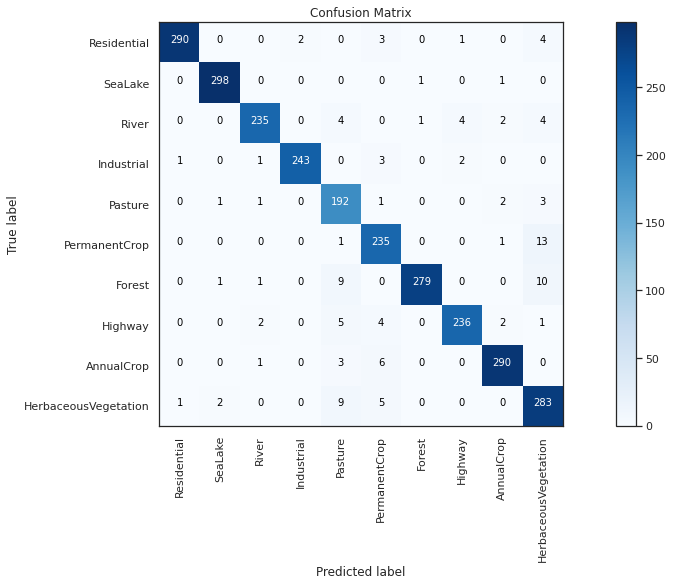

In [52]:
predictions = model.predict_generator(test_batches, steps=270, verbose=0)

# confusion matrix using the results of the model on the test set
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

In [68]:
img_path = test_path + '/Residential/Residential_101.jpg'

img = image.load_img(img_path, target_size=(64, 64))
# img_tensor = image.img_to_array(img)
# img_tensor = np.expand_dims(img_tensor, axis=0)
# img_tensor /= 255.

# plt.imshow(img_tensor[0])
# plt.show()

print(img_tensor.shape)

(1, 64, 64, 3)


In [69]:

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)
print("Predicted class is:",classes)

Predicted class is: [0]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
